In [5]:
# !pip install fake-useragent
# !pip install selenium

In [180]:
from bs4 import BeautifulSoup
import requests
import json
import re
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from IPython.display import HTML
import hvplot.pandas
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from fake_useragent import UserAgent
import time as time
from time import sleep
import random as random
from random import randint
import datetime


def getURL(url):
    try:
        user_agent = {'User-agent': UserAgent().random}
        pageHTML = requests.get(url, headers = user_agent).text
         # Attendre au moins 30 seconds
        sleep_time = 28 + 20 * random.random()      
        time.sleep(sleep_time)
    except:
        return np.NaN

    return pageHTML

def getSoup(url):
    try:
        user_agent = {'User-agent': UserAgent().random}
        pageHTML = requests.get(url, headers = user_agent).text
         # Attendre au moins 30 seconds
        sleep_time = 28 + 20 * random.random()      
        time.sleep(sleep_time)
        soup = BeautifulSoup(pageHTML, 'html5lib')

    except:
        return np.NaN

    return soup


def getIdFilm(element):
    try:
        imdbID = element.find('span','rating-cancel').a['href'].split('/')[2]

    except:
        return np.NaN

    return imdbID

def getTitre(element):
    try:
        titreFilm=element.h3.a.text

    except:
        return np.NaN

    return titreFilm

def getDuree(element):
    
    try:
        duree = element.p.find("span", class_ = 'runtime').text if filmElement.p.find("span", class_ = 'runtime') else np.NaN
        duree = duree.upper().replace("MIN","").strip()
            
    except:
        return np.NaN
    
    return pd.to_numeric(duree.strip())

    
def getVotes(element):
    try:
        value = filmElement.find_all('span', attrs = {'name': "nv"})
        votes = value[0].text if filmElement.find_all('span', attrs = {'name': "nv"}) else np.NaN

    except:
        return np.NaN

    return pd.to_numeric(votes.replace(",",""))

    
def getGenresListe(soup):
    try:
        data = soup.find('script', text=re.compile("contentRating"))
        json_object = json.loads(data.contents[0])

    except:
        return np.NaN
    
    return json_object['genre']

def getDateSortie(soup):
    try:
        data = soup.find('script', text=re.compile("contentRating"))
        json_object = json.loads(data.contents[0])
        dateRelease=json_object['datePublished']

    except:
        return np.NaN
    
    return dateRelease

def getNotes(filmElement):
    try:
         rating = filmElement.find('div', class_ = "inline-block ratings-imdb-rating").text.replace('\n', '') if filmElement.find('div', class_ = "inline-block ratings-imdb-rating") else np.NaN

    except:
        return np.NaN
    
    return pd.to_numeric(rating)

In [ ]:
####################################################################
##### collecte les données ###############
####################################################################

print ("Début de traitement: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

noPage = 3
noStart=101
columns=['idFilm', 'titreFilm', 'duree', 'genresListe', 'dateSortie', 'utilisateurNote', 'nbreUtilisateurVote']
pageSuivante="https://www.imdb.com/search/title/?title_type=feature&release_date=2018-01-01,2018-12-31&start=" + str(noStart) + "&ref_=adv_nxt"
pagePrecedente=""
firstTime=True

user_agent = {'User-agent': UserAgent().random}
pageHTML = requests.get(pageSuivante, headers = user_agent).text
 # Attendre au moins 30 seconds
sleep_time = 28 + 20 * random.random()      
time.sleep(sleep_time)

while pagePrecedente != pageSuivante: 
        soup = BeautifulSoup(pageHTML, 'html5lib')
        pagePrecedente = pageSuivante

        donnees=[]
        listeFilmes = soup.findAll('div', attrs = {'class': 'lister-item mode-advanced'})
        for filmElement in listeFilmes:
            IdFilm=getIdFilm(filmElement)
            titre=getTitre(filmElement)
            duree=getDuree(filmElement)
            notes=getNotes(filmElement)
            votes=getVotes(filmElement)

            # obtenir les détails d'un filme
            user_agent = {'User-agent': UserAgent().random}
            strURL = "https://www.imdb.com/title/" + IdFilm + "/?ref_=adv_li_i"
            pageHTML = requests.get(strURL, headers = user_agent).text
            sleep_time = 28 + 20 * random.random()      
            time.sleep(sleep_time)
            soupFilm = BeautifulSoup(pageHTML, 'html5lib')
            
            genresListe = getGenresListe(soupFilm)   
            dateSortie = getDateSortie(soupFilm)

            donnees.append([IdFilm, titre, duree, genresListe, dateSortie, notes, votes  ])

            if (firstTime):
                pd.DataFrame(donnees, columns=columns).to_csv("imdbMovies.csv", mode='a', encoding='utf_8', index=False) 
                firstTime = False
            else:
                pd.DataFrame(donnees, columns=columns).to_csv("imdbMovies.csv", mode='a', encoding='utf_8', index=False, header=False)    

        print("Numéro de la pages traité est: ", noPage)
        print("Nombre Start traité est: ",noStart)
        
        noPage += 1
        noStart += 50

        pageSuivante="https://www.imdb.com/search/title/?title_type=feature&release_date=2018-01-01,2018-12-31&start=" + str(noStart) + "&ref_=adv_nxt"
        user_agent = {'User-agent': UserAgent().random}
        pageHTML = requests.get(pageSuivante, headers = user_agent).text
         # Attendre au moins 30 seconds
        sleep_time = 28 + 20 * random.random()      
        time.sleep(sleep_time)

print("Nombre de total de pages traité est: ",noPage)
print("Nombre de total de start traité est: ",noStart)
print ("Fin de traitement: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

In [171]:
######################################################################################
############## 6. PARTIE 2 :  5.2 EXPLOITATION DES DONNÉES (12PTS) : #################
######################################################################################

dfdata = pd.read_csv("imdb_movies.csv")
display(dfdata)
pd.set_option('display.max_rows',10)


print("Supprimer les films dont la durée n’est pas enregistrée.")
# 3. Supprimer les films dont la durée est égale à 0. 
# 4. Supprimer les films dont la durée est très élevée. 
Q1 = dfdata["duree"].quantile(0.25)
Q3 = dfdata["duree"].quantile(0.75)
IQR = Q3 - Q1
max = dfdata["duree"] > (Q3 + 1.5 * IQR)
min = dfdata["duree"] < (Q1 - 1.5 * IQR)
index = ~(max | min)
dfdata = dfdata[index]
print(dfdata)

# Retirer les virgules
dfdata['nbreUtilisateurVote'].replace(',','', regex=True, inplace=True)
dfdata["utilisateurNote"].fillna(dfdata["utilisateurNote"].median(), inplace=True)
dfdata["nbreUtilisateurVote"].fillna(dfdata["nbreUtilisateurVote"].median(), inplace=True)
dfdata=dfdata.dropna(subset=["genresListe"],axis=0).copy()

print("5. Convertir le nombre d’évaluations de chaque film nbre utilisateur note à une valeur entière.")
dfdata['nbreUtilisateurVote'] = dfdata['nbreUtilisateurVote'].astype('int')

# Éliminer les valeurs aberrantes catégoriques"genres_liste"
def calcul_frequence(x, table_frequence):
    return table_frequence[x]

table_frequence = dfdata["genresListe"].value_counts() 
index = dfdata["genresListe"].apply(lambda x : calcul_frequence(x, table_frequence)) > 1 
dfdata = dfdata[index]
print("Table de fréquences: ")
display(table_frequence)

# Éliminer les valeurs aberrantes numériques column"utilisateur_note"
Q1 = dfdata["utilisateurNote"].quantile(0.25)
Q3 = dfdata["utilisateurNote"].quantile(0.75)
IQR = Q3 - Q1
max = dfdata["utilisateurNote"] > (Q3 + 1.5 * IQR)
min = dfdata["utilisateurNote"] < (Q1 - 1.5 * IQR)
index = ~(max | min)
dfdata = dfdata[index]
print(dfdata)

# 6.Supprimer les films qui ont un nombre d’évaluations très élevée. 
# Éliminer les valeurs aberrantes numériques column"nbreUtilisateurVote"
Q1 = dfdata["nbreUtilisateurVote"].quantile(0.25)
Q3 = dfdata["nbreUtilisateurVote"].quantile(0.75)
IQR = Q3 - Q1
max = dfdata["nbreUtilisateurVote"] > (Q3 + 1.5 * IQR)
min = dfdata["nbreUtilisateurVote"] < (Q1 - 1.5 * IQR)
index = ~(max | min)
dfdata = dfdata[index]
print(dfdata)
dfdata.dtypes


dfdata.loc[dfdata['duree']!=dfdata['duree'].max()]
dfdata.drop(dfdata['duree'].idxmax())
dfdata.loc[dfdata['utilisateurNote']!=dfdata['utilisateurNote'].max()]
dfdata.drop(dfdata['utilisateurNote'].idxmax())
display(dfdata)


df_decompte = dfdata['genresListe'].value_counts()
df_cinqPremiers = df_decompte.iloc[0:5]
print("\nLes 5 genres les plus cités sont:\n")
print(df_decompte)

print("\nLes autres catégories restantes")
df_restant = df_decompte.iloc[5:]
print(df_restant)

print("\n7. Créer une colonne pour chaque genre. Il ne faut laisser que les 5 genres les plus cités et regrouper le reste dans une colonne autres genres.")
for a,b in dfdata.iterrows():
    strGenre = b['genresListe'].upper()
    strSplitGenre = strGenre.split(',')
    
    dfdata.at[a, 'Comedy'] = dfdata.at[a, 'Drama'] = dfdata.at[a, 'Horror'] = dfdata.at[a, 'Thriller'] = dfdata.at[a, 'Action'] = dfdata.at[a, 'genre_cat'] = np.NaN
    
    strtempRemove = ""
    for i in range(0, len(strSplitGenre)):
        strGenre = strSplitGenre[i].strip()
            
        if strGenre == 'COMEDY':
            dfdata.at[a, 'Comedy'] = 'Comedy'
            strtempRemove = strtempRemove + 'Comedy,'

        elif strGenre == 'DRAMA':
            dfdata.at[a, 'Drama'] = 'Drama' 
            strtempRemove = strtempRemove + 'Drama,'

        elif strGenre == 'HORROR':
            dfdata.at[a, 'Horror'] = 'Horror'
            strtempRemove = strtempRemove + 'Horror,'

        elif strGenre == 'THRILLER':
            dfdata.at[a, 'Thriller'] = 'Thriller'
            strtempRemove = strtempRemove + 'Thriller,'

        elif strGenre == 'ACTION':
            dfdata.at[a, 'Action'] = 'Action'     
            strtempRemove = strtempRemove + 'Action,'

    # Tous les restants des genres seront regroupé dans la colonne genre_cat
    if strtempRemove == "":
        dfdata.at[a, 'genre_cat'] = b['genresListe']
    else:
        dfdata.at[a, 'genre_cat'] = b['genresListe'].replace(strtempRemove,"")

print("\n9. Supprimer les films qui n’ont pas de date de sortie enregistrée.")
dfdata=dfdata.dropna(subset=["dateSortie"],axis=0).copy()
display(dfdata)


idFilm                      titreFilm  duree  \
0       1825683                  Black Panther  134.0   
1       7784604                     Hereditary  127.0   
2       4560436                        Mile 22   94.0   
3       4154756         Avengers: Infinity War  149.0   
4       1034415                       Suspiria  152.0   
...         ...                            ...    ...   
12913  23724074         VÃ­ctimas de tratantes   89.0   
12914  23731006                  My Final Wife    NaN   
12915  23751842                      Boys Club    NaN   
12916  23768836  El diario de una prostituta 3    NaN   
12917  23769210             Perras de barrio 5    NaN   

                     genresListe  dateSortie  utilisateurNote  \
0      Action, Adventure, Sci-Fi  2018-02-16              7.3   
1         Drama, Horror, Mystery  2018-06-08              7.3   
2               Action, Thriller  2018-08-17              6.1   
3      Action, Adventure, Sci-Fi  2018-04-27              8.4   
4         Drama, Fantasy, Horror  2018-11-02              6.7   
...                          ...         ...              ...   
12913                      Drama         NaN              NaN   
12914                      Drama  2018-10-27              NaN   
12915                        NaN  2018-03-18              NaN   
12916                      Drama         NaN              NaN   
12917                      Drama         NaN              NaN   

      nbreUtilisateurVote  
0                 762,371  
1                 315,114  
2                  80,319  
3               1,071,036  
4                  79,179  
...                   ...  
12913                 NaN  
12914                 NaN  
12915                 NaN  
12916                 NaN  
12917                 NaN  

[12918 rows x 7 columns]

Supprimer les films dont la durée n’est pas enregistrée.
         idFilm                      titreFilm  duree  \
0       1825683                  Black Panther  134.0   
1       7784604                     Hereditary  127.0   
2       4560436                        Mile 22   94.0   
5       5083738                  The Favourite  119.0   
6       1677720               Ready Player One  140.0   
...         ...                            ...    ...   
12913  23724074         VÃ­ctimas de tratantes   89.0   
12914  23731006                  My Final Wife    NaN   
12915  23751842                      Boys Club    NaN   
12916  23768836  El diario de una prostituta 3    NaN   
12917  23769210             Perras de barrio 5    NaN   

                     genresListe  dateSortie  utilisateurNote  \
0      Action, Adventure, Sci-Fi  2018-02-16              7.3   
1         Drama, Horror, Mystery  2018-06-08              7.3   
2               Action, Thriller  2018-08-17              6.1  

Drama                         3136
Comedy                        1157
Horror                         568
Thriller                       446
Comedy, Drama                  437
                              ... 
Family, Sci-Fi                   1
Action, Comedy, Western          1
Drama, Family, History           1
Drama, Reality-TV, Romance       1
Music, Musical, Reality-TV       1
Name: genresListe, Length: 472, dtype: int64

         idFilm                      titreFilm  duree  \
0       1825683                  Black Panther  134.0   
1       7784604                     Hereditary  127.0   
2       4560436                        Mile 22   94.0   
9       1843303               The VelociPastor   75.0   
12      1477834                        Aquaman  143.0   
...         ...                            ...    ...   
12912  23722356                          Efeyo    NaN   
12913  23724074         VÃ­ctimas de tratantes   89.0   
12914  23731006                  My Final Wife    NaN   
12916  23768836  El diario de una prostituta 3    NaN   
12917  23769210             Perras de barrio 5    NaN   

                      genresListe  dateSortie  utilisateurNote  \
0       Action, Adventure, Sci-Fi  2018-02-16              7.3   
1          Drama, Horror, Mystery  2018-06-08              7.3   
2                Action, Thriller  2018-08-17              6.1   
9       Action, Adventure, Comedy  2019-08-13      

idFilm                              titreFilm  duree  \
297     7490386                                    Mar  103.0   
453     9081562  Bi bei shang geng bei shang de gu shi  105.0   
540     5233090                                   Yinz   89.0   
579     6888362                   Enthusiastic Sinners   85.0   
620     6096308                                  Still   96.0   
...         ...                                    ...    ...   
12912  23722356                                  Efeyo    NaN   
12913  23724074                 VÃ­ctimas de tratantes   89.0   
12914  23731006                          My Final Wife    NaN   
12916  23768836          El diario de una prostituta 3    NaN   
12917  23769210                     Perras de barrio 5    NaN   

                   genresListe  dateSortie  utilisateurNote  \
297                      Drama  2019-05-16              5.5   
453                    Romance  2018-11-30              6.2   
540                   Thriller  2018-10-19              5.1   
579             Drama, Romance  2019-10-08              6.1   
620    Drama, Fantasy, Mystery  2019-01-08              5.2   
...                        ...         ...              ...   
12912                    Drama  2018-12-08              5.9   
12913                    Drama         NaN              5.9   
12914                    Drama  2018-10-27              5.9   
12916                    Drama         NaN              5.9   
12917                    Drama         NaN              5.9   

       nbreUtilisateurVote  
297                     49  
453                    124  
540                    120  
579                    131  
620                    124  
...                    ...  
12912                  107  
12913                  107  
12914                  107  
12916                  107  
12917                  107  

[5955 rows x 7 columns]


Les 5 genres les plus cités sont:

Drama                        1946
Comedy                        606
Horror                        249
Thriller                      247
Action                        238
                             ... 
Adventure, Drama, Romance       1
Comedy, Family, Musical         1
Crime, Drama, Music             1
Comedy, Family, Music           1
Action, Adventure, Sci-Fi       1
Name: genresListe, Length: 268, dtype: int64

Les autres catégories restantes
Comedy, Drama                182
Romance                      150
Drama, Romance               125
Animation                     93
Music                         83
                            ... 
Adventure, Drama, Romance      1
Comedy, Family, Musical        1
Crime, Drama, Music            1
Comedy, Family, Music          1
Action, Adventure, Sci-Fi      1
Name: genresListe, Length: 263, dtype: int64

7. Créer une colonne pour chaque genre. Il ne faut laisser que les 5 genres les plus cités et regrouper

idFilm                              titreFilm  duree  \
297     7490386                                    Mar  103.0   
453     9081562  Bi bei shang geng bei shang de gu shi  105.0   
540     5233090                                   Yinz   89.0   
579     6888362                   Enthusiastic Sinners   85.0   
620     6096308                                  Still   96.0   
...         ...                                    ...    ...   
12909  23625874                    David Paquet's 2h14    NaN   
12910  23657832                            Unwise King    NaN   
12911  23711076                                   Zoli    NaN   
12912  23722356                                  Efeyo    NaN   
12914  23731006                          My Final Wife    NaN   

                   genresListe  dateSortie  utilisateurNote  \
297                      Drama  2019-05-16              5.5   
453                    Romance  2018-11-30              6.2   
540                   Thriller  2018-10-19              5.1   
579             Drama, Romance  2019-10-08              6.1   
620    Drama, Fantasy, Mystery  2019-01-08              5.2   
...                        ...         ...              ...   
12909                    Drama  2018-05-25              5.9   
12910                    Drama  2018-07-06              5.9   
12911                    Drama  2018-12-07              5.9   
12912                    Drama  2018-12-08              5.9   
12914                    Drama  2018-10-27              5.9   

       nbreUtilisateurVote Comedy  Drama Horror  Thriller Action  \
297                     49    NaN  Drama    NaN       NaN    NaN   
453                    124    NaN    NaN    NaN       NaN    NaN   
540                    120    NaN    NaN    NaN  Thriller    NaN   
579                    131    NaN  Drama    NaN       NaN    NaN   
620                    124    NaN  Drama    NaN       NaN    NaN   
...                    ...    ...    ...    ...       ...    ...   
12909                  107    NaN  Drama    NaN       NaN    NaN   
12910                  107    NaN  Drama    NaN       NaN    NaN   
12911                  107    NaN  Drama    NaN       NaN    NaN   
12912                  107    NaN  Drama    NaN       NaN    NaN   
12914                  107    NaN  Drama    NaN       NaN    NaN   

               genre_cat  
297                Drama  
453              Romance  
540             Thriller  
579              Romance  
620     Fantasy, Mystery  
...                  ...  
12909              Drama  
12910              Drama  
12911              Drama  
12912              Drama  
12914              Drama  

[4620 rows x 13 columns]

In [172]:
dfdata=dfdata.dropna(subset=["duree"],axis=0).copy()
display(dfdata)

idFilm                                     titreFilm  duree  \
297     7490386                                           Mar  103.0   
453     9081562         Bi bei shang geng bei shang de gu shi  105.0   
540     5233090                                          Yinz   89.0   
579     6888362                          Enthusiastic Sinners   85.0   
620     6096308                                         Still   96.0   
...         ...                                           ...    ...   
12897  12796236                         El velorio (The Wake)   61.0   
12898  11647038                                  Rieg - 12:00   79.0   
12904   8280720                                            3X  120.0   
12905   7279608  Deep Meaning aka: Neglect, Hate & Self Shame   52.0   
12907  12539530                                 Hume Jeene Do   52.0   

                   genresListe  dateSortie  utilisateurNote  \
297                      Drama  2019-05-16              5.5   
453                    Romance  2018-11-30              6.2   
540                   Thriller  2018-10-19              5.1   
579             Drama, Romance  2019-10-08              6.1   
620    Drama, Fantasy, Mystery  2019-01-08              5.2   
...                        ...         ...              ...   
12897                  Fantasy  2018-01-12              5.9   
12898                    Music  2018-04-20              5.9   
12904                    Drama  2018-07-24              5.9   
12905         Animation, Drama  2018-08-11              5.9   
12907                    Drama  2018-01-22              5.9   

       nbreUtilisateurVote Comedy  Drama Horror  Thriller Action  \
297                     49    NaN  Drama    NaN       NaN    NaN   
453                    124    NaN    NaN    NaN       NaN    NaN   
540                    120    NaN    NaN    NaN  Thriller    NaN   
579                    131    NaN  Drama    NaN       NaN    NaN   
620                    124    NaN  Drama    NaN       NaN    NaN   
...                    ...    ...    ...    ...       ...    ...   
12897                  107    NaN    NaN    NaN       NaN    NaN   
12898                  107    NaN    NaN    NaN       NaN    NaN   
12904                  107    NaN  Drama    NaN       NaN    NaN   
12905                  107    NaN  Drama    NaN       NaN    NaN   
12907                  107    NaN  Drama    NaN       NaN    NaN   

               genre_cat  
297                Drama  
453              Romance  
540             Thriller  
579              Romance  
620     Fantasy, Mystery  
...                  ...  
12897            Fantasy  
12898              Music  
12904              Drama  
12905   Animation, Drama  
12907              Drama  

[3133 rows x 13 columns]

In [173]:

####################################################################################
print("\n 6.2 Créer 2 nouvelles colonnes durée minutes log, nbre_utilisateur_note_log")
dfdata['dureeMinutesLog'] = np.log2(dfdata['duree'])
dfdata['nbreUtilisateurNoteLog'] = np.log2(dfdata['nbreUtilisateurVote'])
display(dfdata)


 6.2 Créer 2 nouvelles colonnes durée minutes log, nbre_utilisateur_note_log


idFilm                                     titreFilm  duree  \
297     7490386                                           Mar  103.0   
453     9081562         Bi bei shang geng bei shang de gu shi  105.0   
540     5233090                                          Yinz   89.0   
579     6888362                          Enthusiastic Sinners   85.0   
620     6096308                                         Still   96.0   
...         ...                                           ...    ...   
12897  12796236                         El velorio (The Wake)   61.0   
12898  11647038                                  Rieg - 12:00   79.0   
12904   8280720                                            3X  120.0   
12905   7279608  Deep Meaning aka: Neglect, Hate & Self Shame   52.0   
12907  12539530                                 Hume Jeene Do   52.0   

                   genresListe  dateSortie  utilisateurNote  \
297                      Drama  2019-05-16              5.5   
453                    Romance  2018-11-30              6.2   
540                   Thriller  2018-10-19              5.1   
579             Drama, Romance  2019-10-08              6.1   
620    Drama, Fantasy, Mystery  2019-01-08              5.2   
...                        ...         ...              ...   
12897                  Fantasy  2018-01-12              5.9   
12898                    Music  2018-04-20              5.9   
12904                    Drama  2018-07-24              5.9   
12905         Animation, Drama  2018-08-11              5.9   
12907                    Drama  2018-01-22              5.9   

       nbreUtilisateurVote Comedy  Drama Horror  Thriller Action  \
297                     49    NaN  Drama    NaN       NaN    NaN   
453                    124    NaN    NaN    NaN       NaN    NaN   
540                    120    NaN    NaN    NaN  Thriller    NaN   
579                    131    NaN  Drama    NaN       NaN    NaN   
620                    124    NaN  Drama    NaN       NaN    NaN   
...                    ...    ...    ...    ...       ...    ...   
12897                  107    NaN    NaN    NaN       NaN    NaN   
12898                  107    NaN    NaN    NaN       NaN    NaN   
12904                  107    NaN  Drama    NaN       NaN    NaN   
12905                  107    NaN  Drama    NaN       NaN    NaN   
12907                  107    NaN  Drama    NaN       NaN    NaN   

               genre_cat  dureeMinutesLog  nbreUtilisateurNoteLog  
297                Drama         6.686501                5.614710  
453              Romance         6.714246                6.954196  
540             Thriller         6.475733                6.906891  
579              Romance         6.409391                7.033423  
620     Fantasy, Mystery         6.584963                6.954196  
...                  ...              ...                     ...  
12897            Fantasy         5.930737                6.741467  
12898              Music         6.303781                6.741467  
12904              Drama         6.906891                6.741467  
12905   Animation, Drama         5.700440                6.741467  
12907              Drama         5.700440                6.741467  

[3133 rows x 15 columns]

In [174]:
###########################################################################################################################
########### 6.3 Réaliser une analyse univariée complète avec les visualisations adéquates et interpréter les résultats.
###########################################################################################################################

df_train = dfdata.set_index("idFilm")
display(df_train.head())

# Préparation de données
y = targets = labels = output_var = df_train["utilisateurNote"]
X = predictors = input_var = df_train.loc[:,df_train.columns != "utilisateurNote"]
display(X.head())

print(y.head())
print("Input Variables", list(X.columns))
print("Output Variable", "['utilisateurNote']")

print("\nidentifier les types de données.")
datatype = dfdata.dtypes
num_col = datatype[(datatype == 'float64') | (datatype == 'int64')].index.tolist()
cat_col = datatype[(datatype == 'object')].index.tolist()
print("Categorical Columns :",cat_col)
print("Numerical Columns :",num_col)

dfdata[dfdata.columns[1:]].describe(include = ['float64','int64','int32'])


titreFilm  duree  \
idFilm                                                  
7490386                                    Mar  103.0   
9081562  Bi bei shang geng bei shang de gu shi  105.0   
5233090                                   Yinz   89.0   
6888362                   Enthusiastic Sinners   85.0   
6096308                                  Still   96.0   

                     genresListe  dateSortie  utilisateurNote  \
idFilm                                                          
7490386                    Drama  2019-05-16              5.5   
9081562                  Romance  2018-11-30              6.2   
5233090                 Thriller  2018-10-19              5.1   
6888362           Drama, Romance  2019-10-08              6.1   
6096308  Drama, Fantasy, Mystery  2019-01-08              5.2   

         nbreUtilisateurVote Comedy  Drama Horror  Thriller Action  \
idFilm                                                               
7490386                   49    NaN  Drama    NaN       NaN    NaN   
9081562                  124    NaN    NaN    NaN       NaN    NaN   
5233090                  120    NaN    NaN    NaN  Thriller    NaN   
6888362                  131    NaN  Drama    NaN       NaN    NaN   
6096308                  124    NaN  Drama    NaN       NaN    NaN   

                 genre_cat  dureeMinutesLog  nbreUtilisateurNoteLog  
idFilm                                                               
7490386              Drama         6.686501                5.614710  
9081562            Romance         6.714246                6.954196  
5233090           Thriller         6.475733                6.906891  
6888362            Romance         6.409391                7.033423  
6096308   Fantasy, Mystery         6.584963                6.954196

titreFilm  duree  \
idFilm                                                  
7490386                                    Mar  103.0   
9081562  Bi bei shang geng bei shang de gu shi  105.0   
5233090                                   Yinz   89.0   
6888362                   Enthusiastic Sinners   85.0   
6096308                                  Still   96.0   

                     genresListe  dateSortie  nbreUtilisateurVote Comedy  \
idFilm                                                                     
7490386                    Drama  2019-05-16                   49    NaN   
9081562                  Romance  2018-11-30                  124    NaN   
5233090                 Thriller  2018-10-19                  120    NaN   
6888362           Drama, Romance  2019-10-08                  131    NaN   
6096308  Drama, Fantasy, Mystery  2019-01-08                  124    NaN   

         Drama Horror  Thriller Action          genre_cat  dureeMinutesLog  \
idFilm                                                                       
7490386  Drama    NaN       NaN    NaN              Drama         6.686501   
9081562    NaN    NaN       NaN    NaN            Romance         6.714246   
5233090    NaN    NaN  Thriller    NaN           Thriller         6.475733   
6888362  Drama    NaN       NaN    NaN            Romance         6.409391   
6096308  Drama    NaN       NaN    NaN   Fantasy, Mystery         6.584963   

         nbreUtilisateurNoteLog  
idFilm                           
7490386                5.614710  
9081562                6.954196  
5233090                6.906891  
6888362                7.033423  
6096308                6.954196

idFilm
7490386    5.5
9081562    6.2
5233090    5.1
6888362    6.1
6096308    5.2
Name: utilisateurNote, dtype: float64
Input Variables ['titreFilm', 'duree', 'genresListe', 'dateSortie', 'nbreUtilisateurVote', 'Comedy', 'Drama', 'Horror', 'Thriller', 'Action', 'genre_cat', 'dureeMinutesLog', 'nbreUtilisateurNoteLog']
Output Variable ['utilisateurNote']

identifier les types de données.
Categorical Columns : ['titreFilm', 'genresListe', 'dateSortie', 'Comedy', 'Drama', 'Horror', 'Thriller', 'Action', 'genre_cat']
Numerical Columns : ['idFilm', 'duree', 'utilisateurNote', 'dureeMinutesLog', 'nbreUtilisateurNoteLog']


duree  utilisateurNote  nbreUtilisateurVote  dureeMinutesLog  \
count  3133.000000      3133.000000          3133.000000      3133.000000   
mean     91.647303         5.916534           107.106288         6.472934   
std      22.134294         0.478551            33.936504         0.369711   
min      45.000000         4.600000            38.000000         5.491853   
25%      78.000000         5.900000           107.000000         6.285402   
50%      90.000000         5.900000           107.000000         6.491853   
75%     105.000000         5.900000           107.000000         6.714246   
max     148.000000         7.300000           222.000000         7.209453   

       nbreUtilisateurNoteLog  
count             3133.000000  
mean                 6.667973  
std                  0.480255  
min                  5.247928  
25%                  6.741467  
50%                  6.741467  
75%                  6.741467  
max                  7.794416

Nombre de répétition de la note


Text(0, 0.5, 'Nombre de repitition de la note')

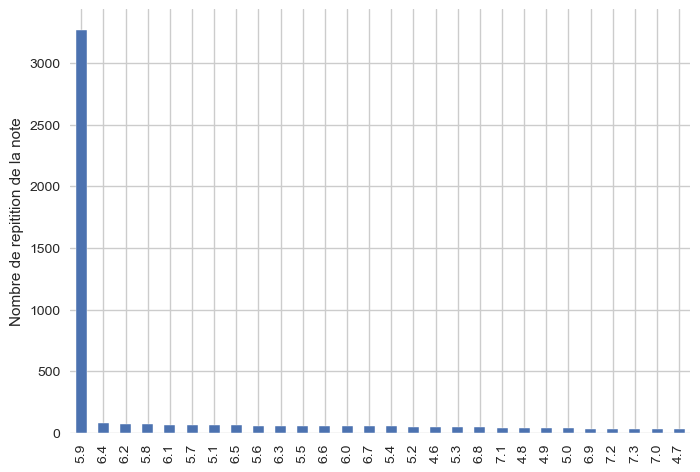

In [138]:
print("Nombre de répétition de la note")
df_utilisateurNote = dfdata['utilisateurNote'].value_counts()
df_utilisateurNote.plot(kind='bar').set_ylabel("Nombre de repitition de la note")

Nombre d’évaluations de chaque film de nbreUtilisateurNote 


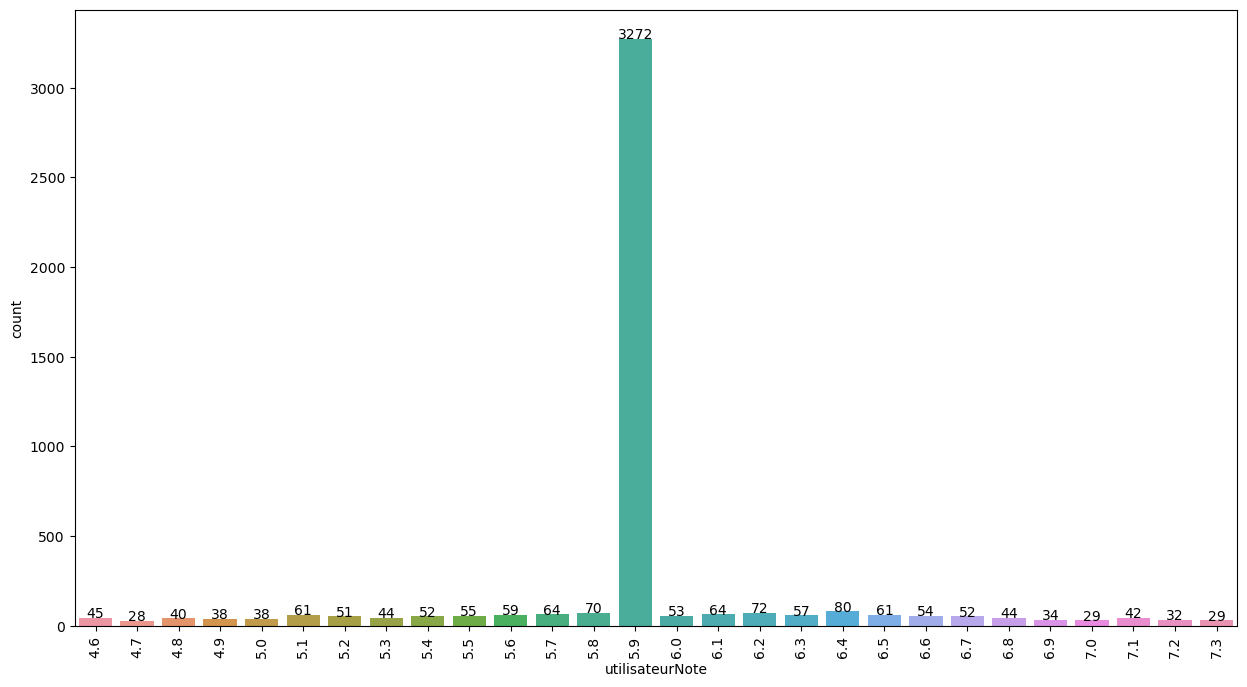

In [16]:
print("Nombre d’évaluations de chaque film de nbreUtilisateurNote ")
fig, ax1 = plt.subplots(figsize=(15,8))
graph = sns.countplot(ax=ax1,x='utilisateurNote', data=dfdata)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)

for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Le décompte de genre


<AxesSubplot:ylabel='genre_cat'>

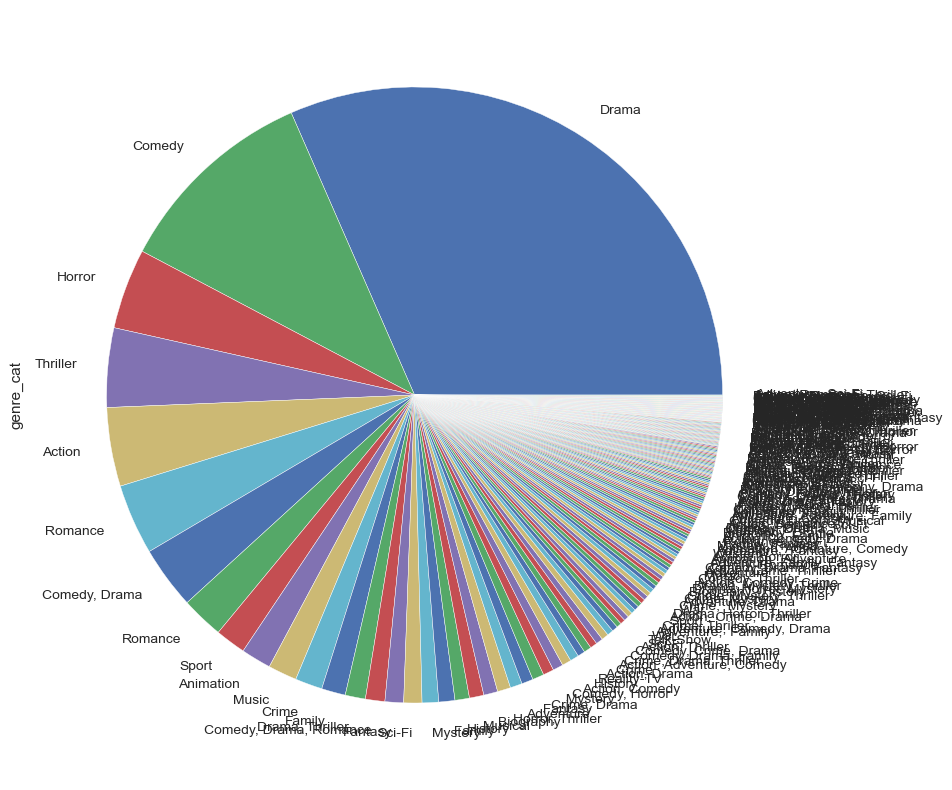

In [139]:
print("Le décompte de genre")
dfdata['genre_cat'].value_counts().plot(kind = 'pie', figsize = (10,10))

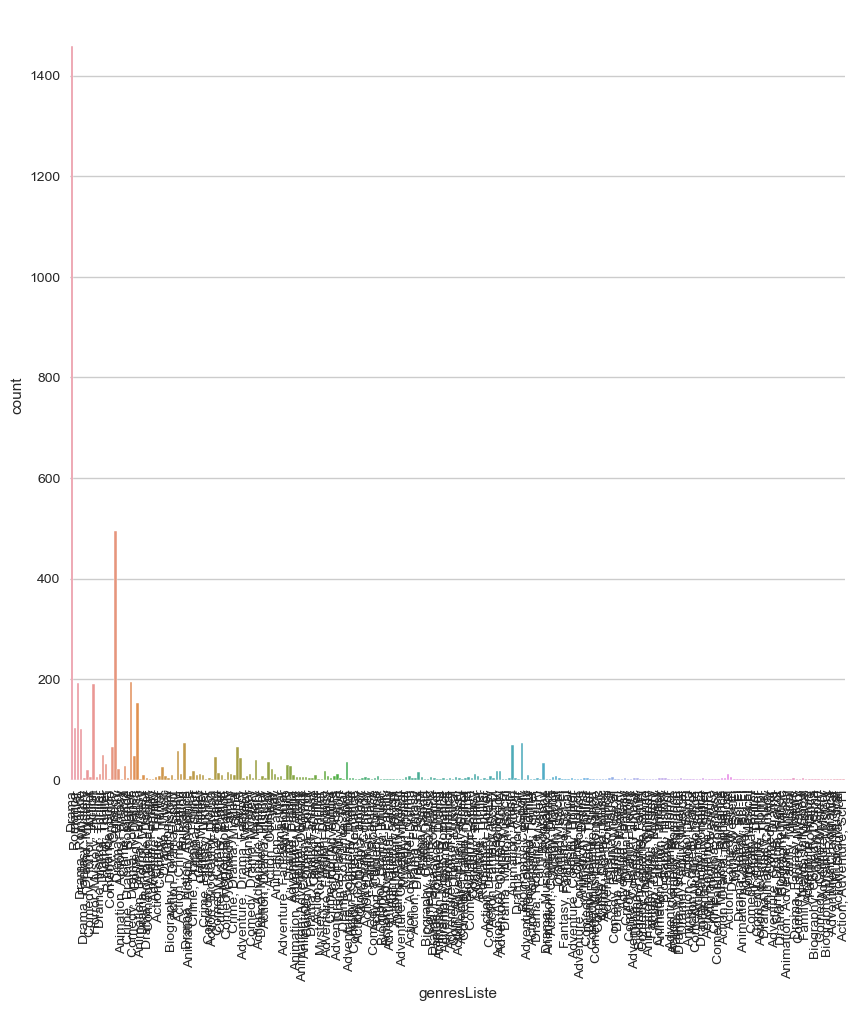

In [140]:
plt.figure(figsize=(10,10))
sns.countplot(x='genresListe', data=dfdata)
plt.xticks(rotation=90)
plt.show()

C:\Users\thack\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


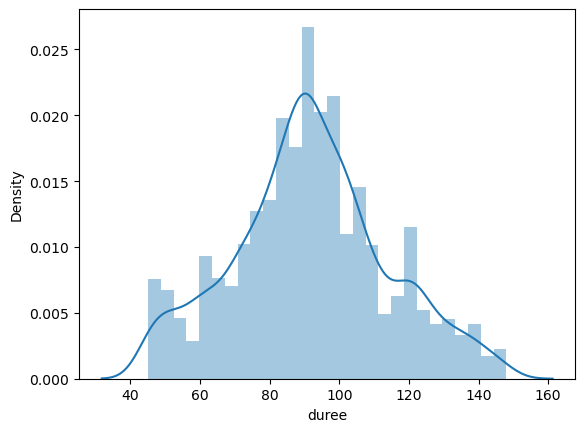

In [39]:
sns.distplot(dfdata['duree'])
plt.show()

The type of the date is now <class 'datetime.datetime'>
The date is 2018-09-19 00:00:00


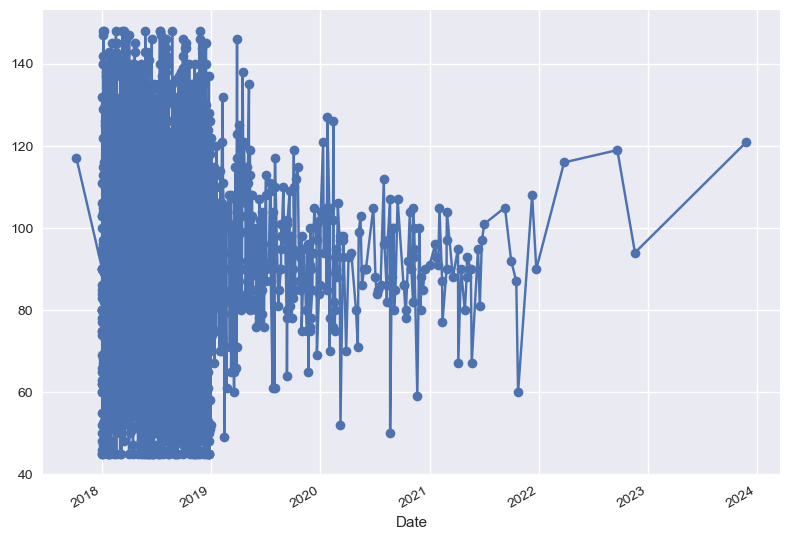

In [175]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')

dfdata['dateSortie'] = pd.to_datetime(dfdata['dateSortie'])
dfdata.sort_values('dateSortie', inplace=True)

price_date = dfdata['dateSortie']
price_close = dfdata['duree']

plt.plot_date(price_date, price_close, linestyle='solid')

plt.gcf().autofmt_xdate()

plt.title('')
plt.xlabel('Date')
plt.ylabel('')

plt.tight_layout()
from datetime import datetime
date_time_obj = datetime.strptime('18/09/19', '%y/%m/%d')


print ("The type of the date is now",  type(date_time_obj))
print ("The date is", date_time_obj)
plt.show()



(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

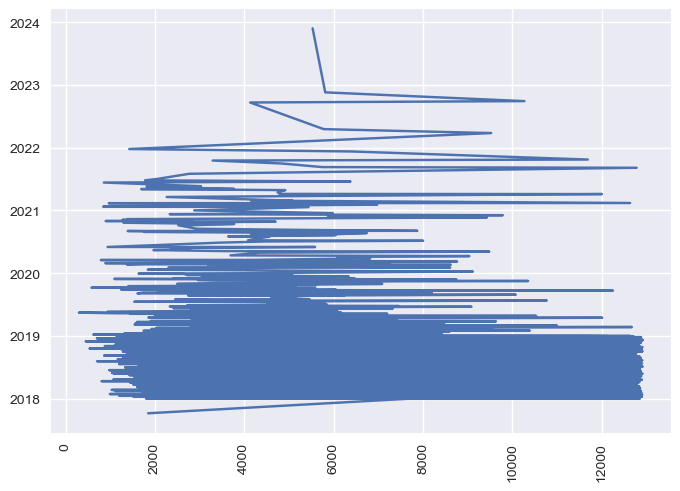

In [143]:
dfdata = dfdata.sort_values('dateSortie', ascending=True)
plt.plot(dfdata['dateSortie'])
plt.xticks(rotation='vertical')

<AxesSubplot:ylabel='dateSortie'>

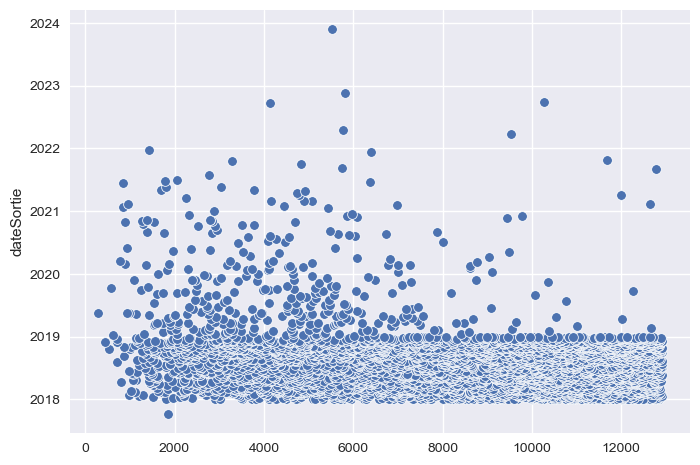

In [144]:
sns.scatterplot(data=dfdata['dateSortie'])

<AxesSubplot:ylabel='duree'>

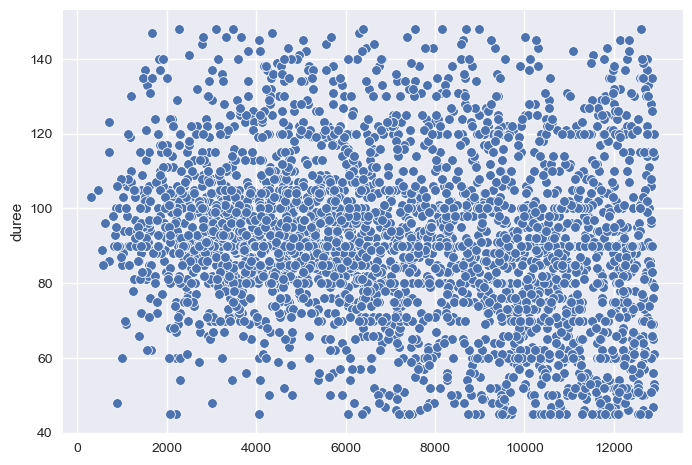

In [145]:
sns.scatterplot(data=dfdata['duree'])

###########################################################################################################################
########### 6.4 Réaliser une analyse bivariée complète avec les visualisations adéquates et interpréter les résultats
###########################################################################################################################


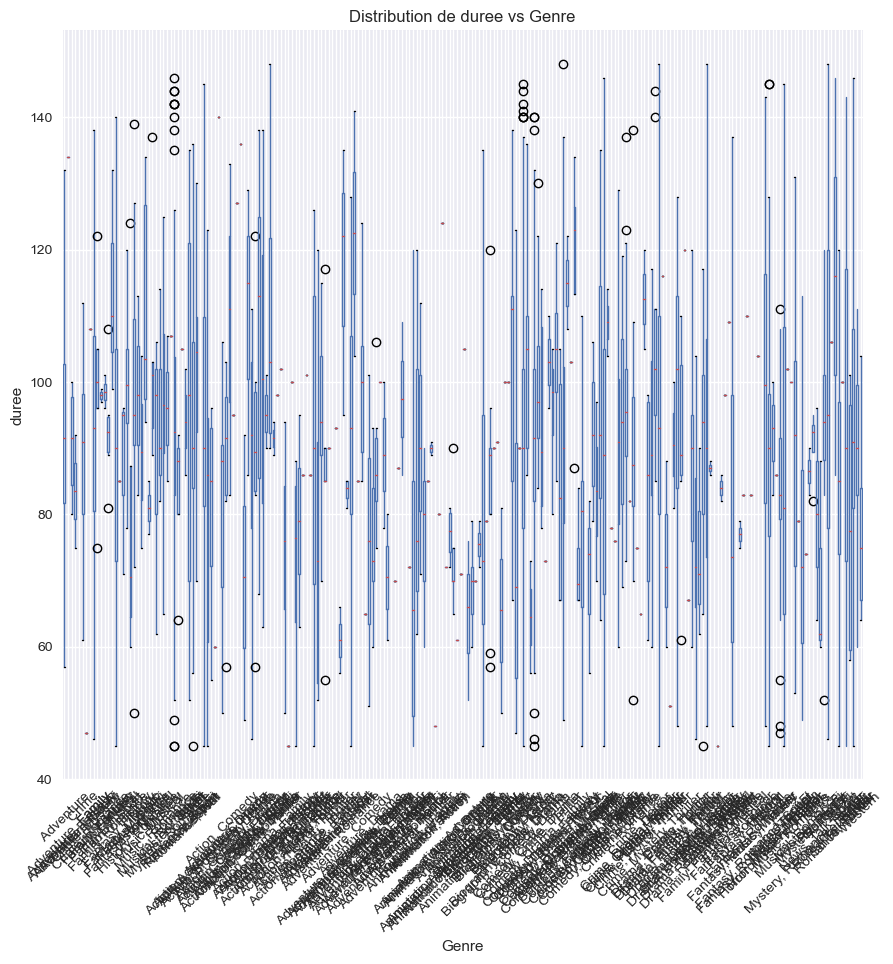

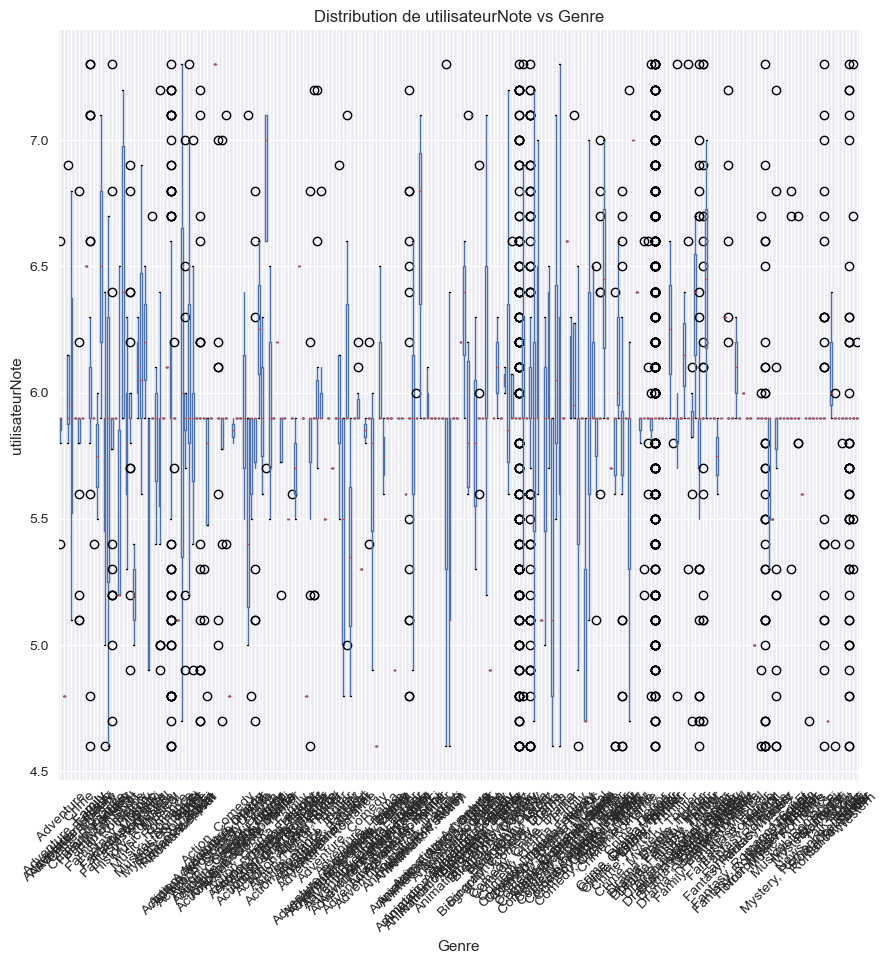

In [146]:
print("###########################################################################################################################")
print("########### 6.4 Réaliser une analyse bivariée complète avec les visualisations adéquates et interpréter les résultats")
print("###########################################################################################################################")

fig1 = dfdata.boxplot(column=['duree'],by ='genre_cat', rot = 45, figsize = (10,10))
# creer Titlre
plt.title('Distribution de duree vs Genre')
plt.suptitle('')
plt.ylabel('duree')
plt.xlabel('Genre')
#Show Plot
plt.show()

#Create Box Plot
fig1 = dfdata.boxplot(column=['utilisateurNote'],by ='genre_cat', rot = 45, figsize = (10,10))
#Create Title
plt.title('Distribution de utilisateurNote vs Genre')
plt.suptitle('')
plt.ylabel('utilisateurNote')
plt.xlabel('Genre')
#Show Plot
plt.show()

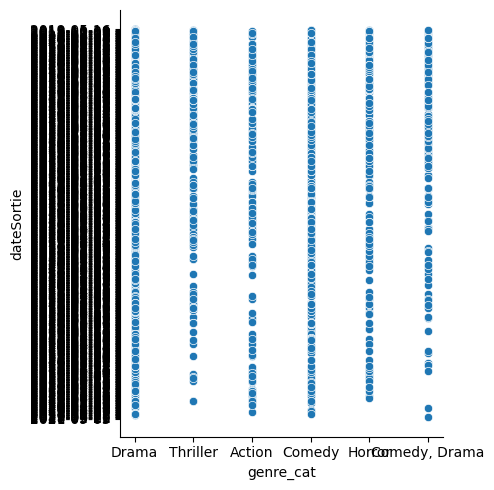

In [11]:
g = sns.relplot( data=dfdata, x="genre_cat", y="dateSortie",  kind="scatter")

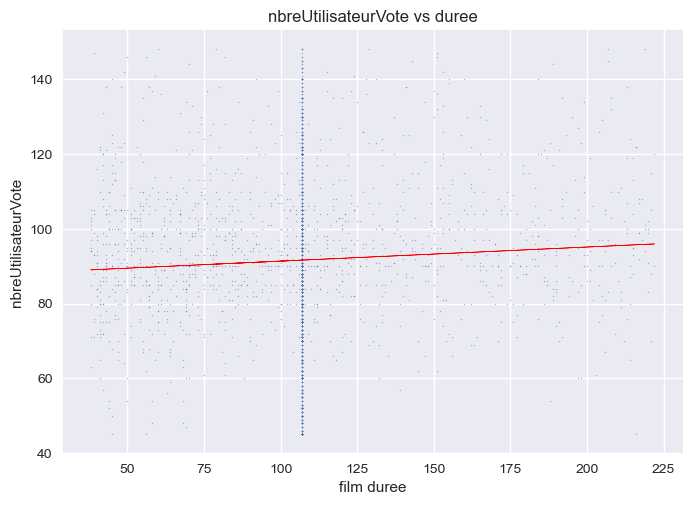

In [176]:
plt.plot(dfdata.nbreUtilisateurVote, dfdata.duree, 'o', markersize =1, alpha = 0.5)
m, b = np.polyfit(dfdata.nbreUtilisateurVote, dfdata.duree, 1)
plt.plot(dfdata.nbreUtilisateurVote, m*dfdata.nbreUtilisateurVote + b, 'red', linewidth = 0.5)
plt.xlabel('film duree')
plt.ylabel('nbreUtilisateurVote')
plt.title('nbreUtilisateurVote vs duree')
plt.show()


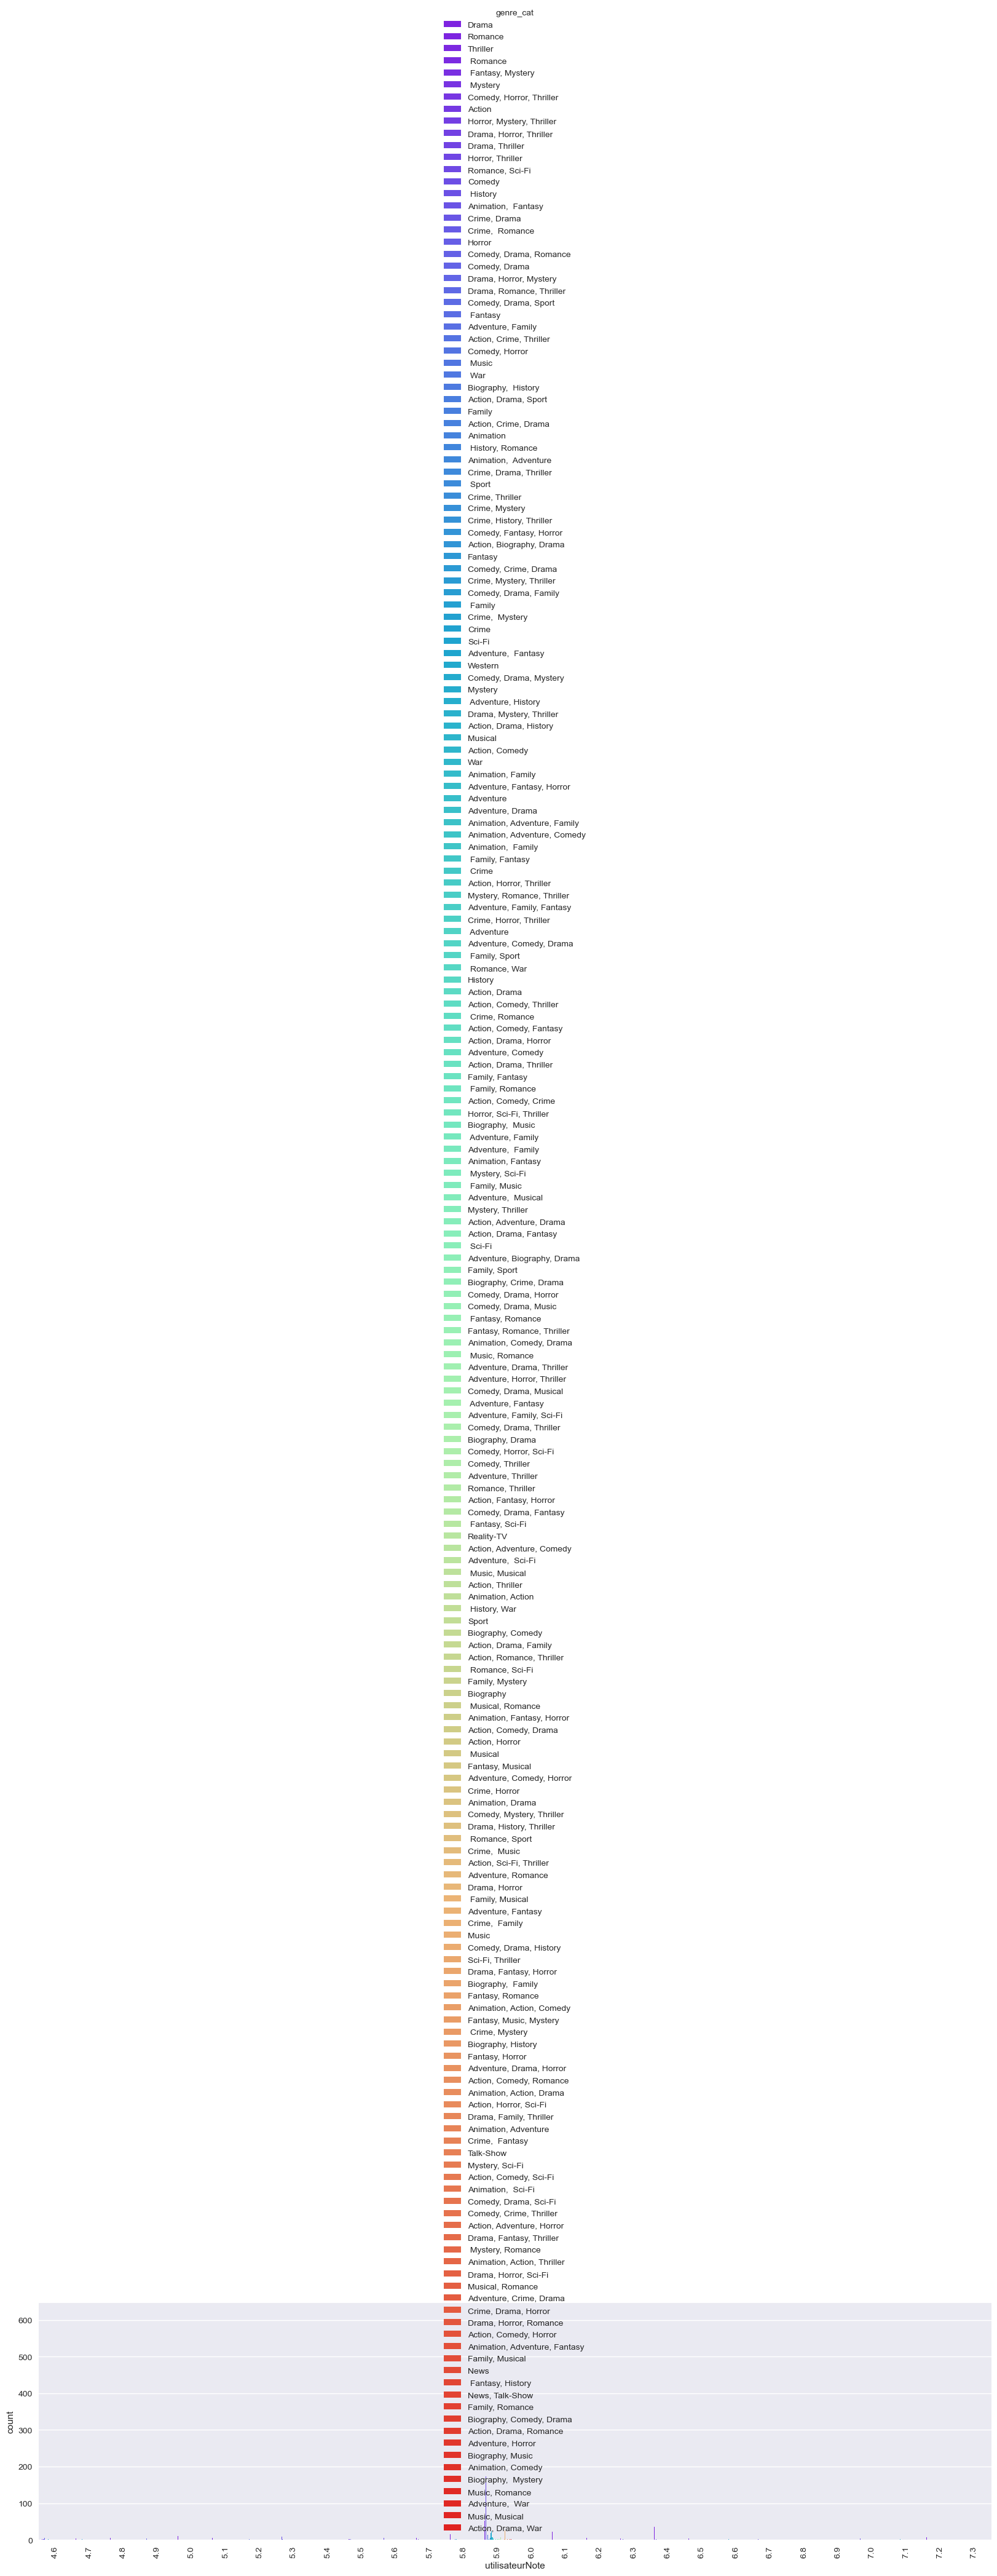

In [177]:
fig, ax1 = plt.subplots(figsize=(20,5))
graph = sns.countplot(ax=ax1,data=df_train,x = "utilisateurNote",hue="genre_cat",palette="rainbow")
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
for p in graph.patches:
    height = p.get_height()

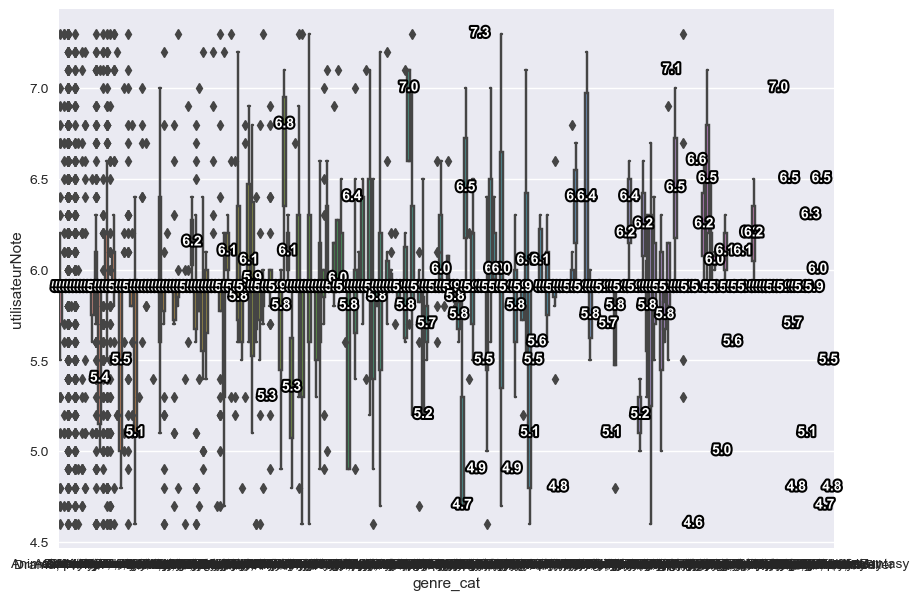

In [149]:
import matplotlib.patheffects as path_effects

fig, ax1 = plt.subplots(figsize=(10,7))

def main():
    sns.set_style("whitegrid")
    tips = dfdata
    # optionally disable fliers
    showfliers = True
    # plot data and create median labels
    box_plot = sns.boxplot(ax=ax1, x='genre_cat', y='utilisateurNote', 
                           #hue='Sex', 
                           data=dfdata,
                           showfliers=showfliers)
    create_median_labels(box_plot.axes, showfliers)
    plt.show()


def create_median_labels(ax, has_fliers):
    lines = ax.get_lines()
    # depending on fliers, toggle between 5 and 6 lines per box
    lines_per_box = 5 + int(has_fliers)
    # iterate directly over all median lines, with an interval of lines_per_box
    # this enables labeling of grouped data without relying on tick positions
    for median_line in lines[4:len(lines):lines_per_box]:
        # get center of median line
        mean_x = sum(median_line._x) / len(median_line._x)
        mean_y = sum(median_line._y) / len(median_line._y)
        # print text to center coordinates
        text = ax.text(mean_x, mean_y, f'{mean_y:.1f}',
                       ha='center', va='center',
                       fontweight='bold', size=10, color='white')
        # create small black border around white text
        # for better readability on multi-colored boxes
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal(),
        ])


if __name__ == '__main__':
    main()

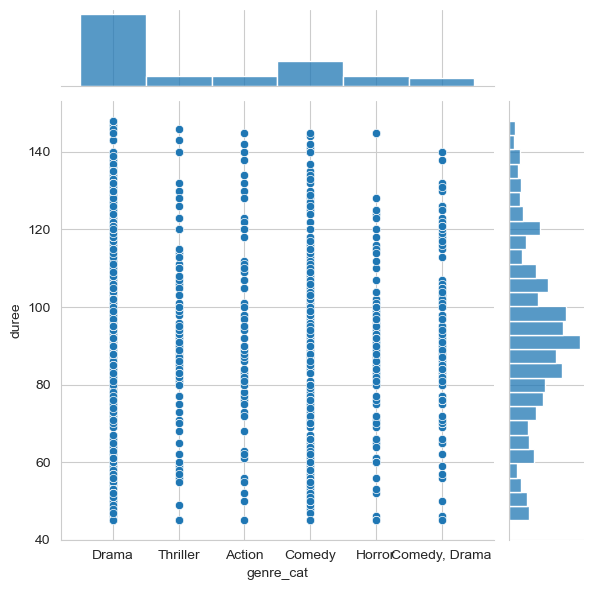

In [23]:
sns.jointplot(x="genre_cat",y="duree",data=df_train)

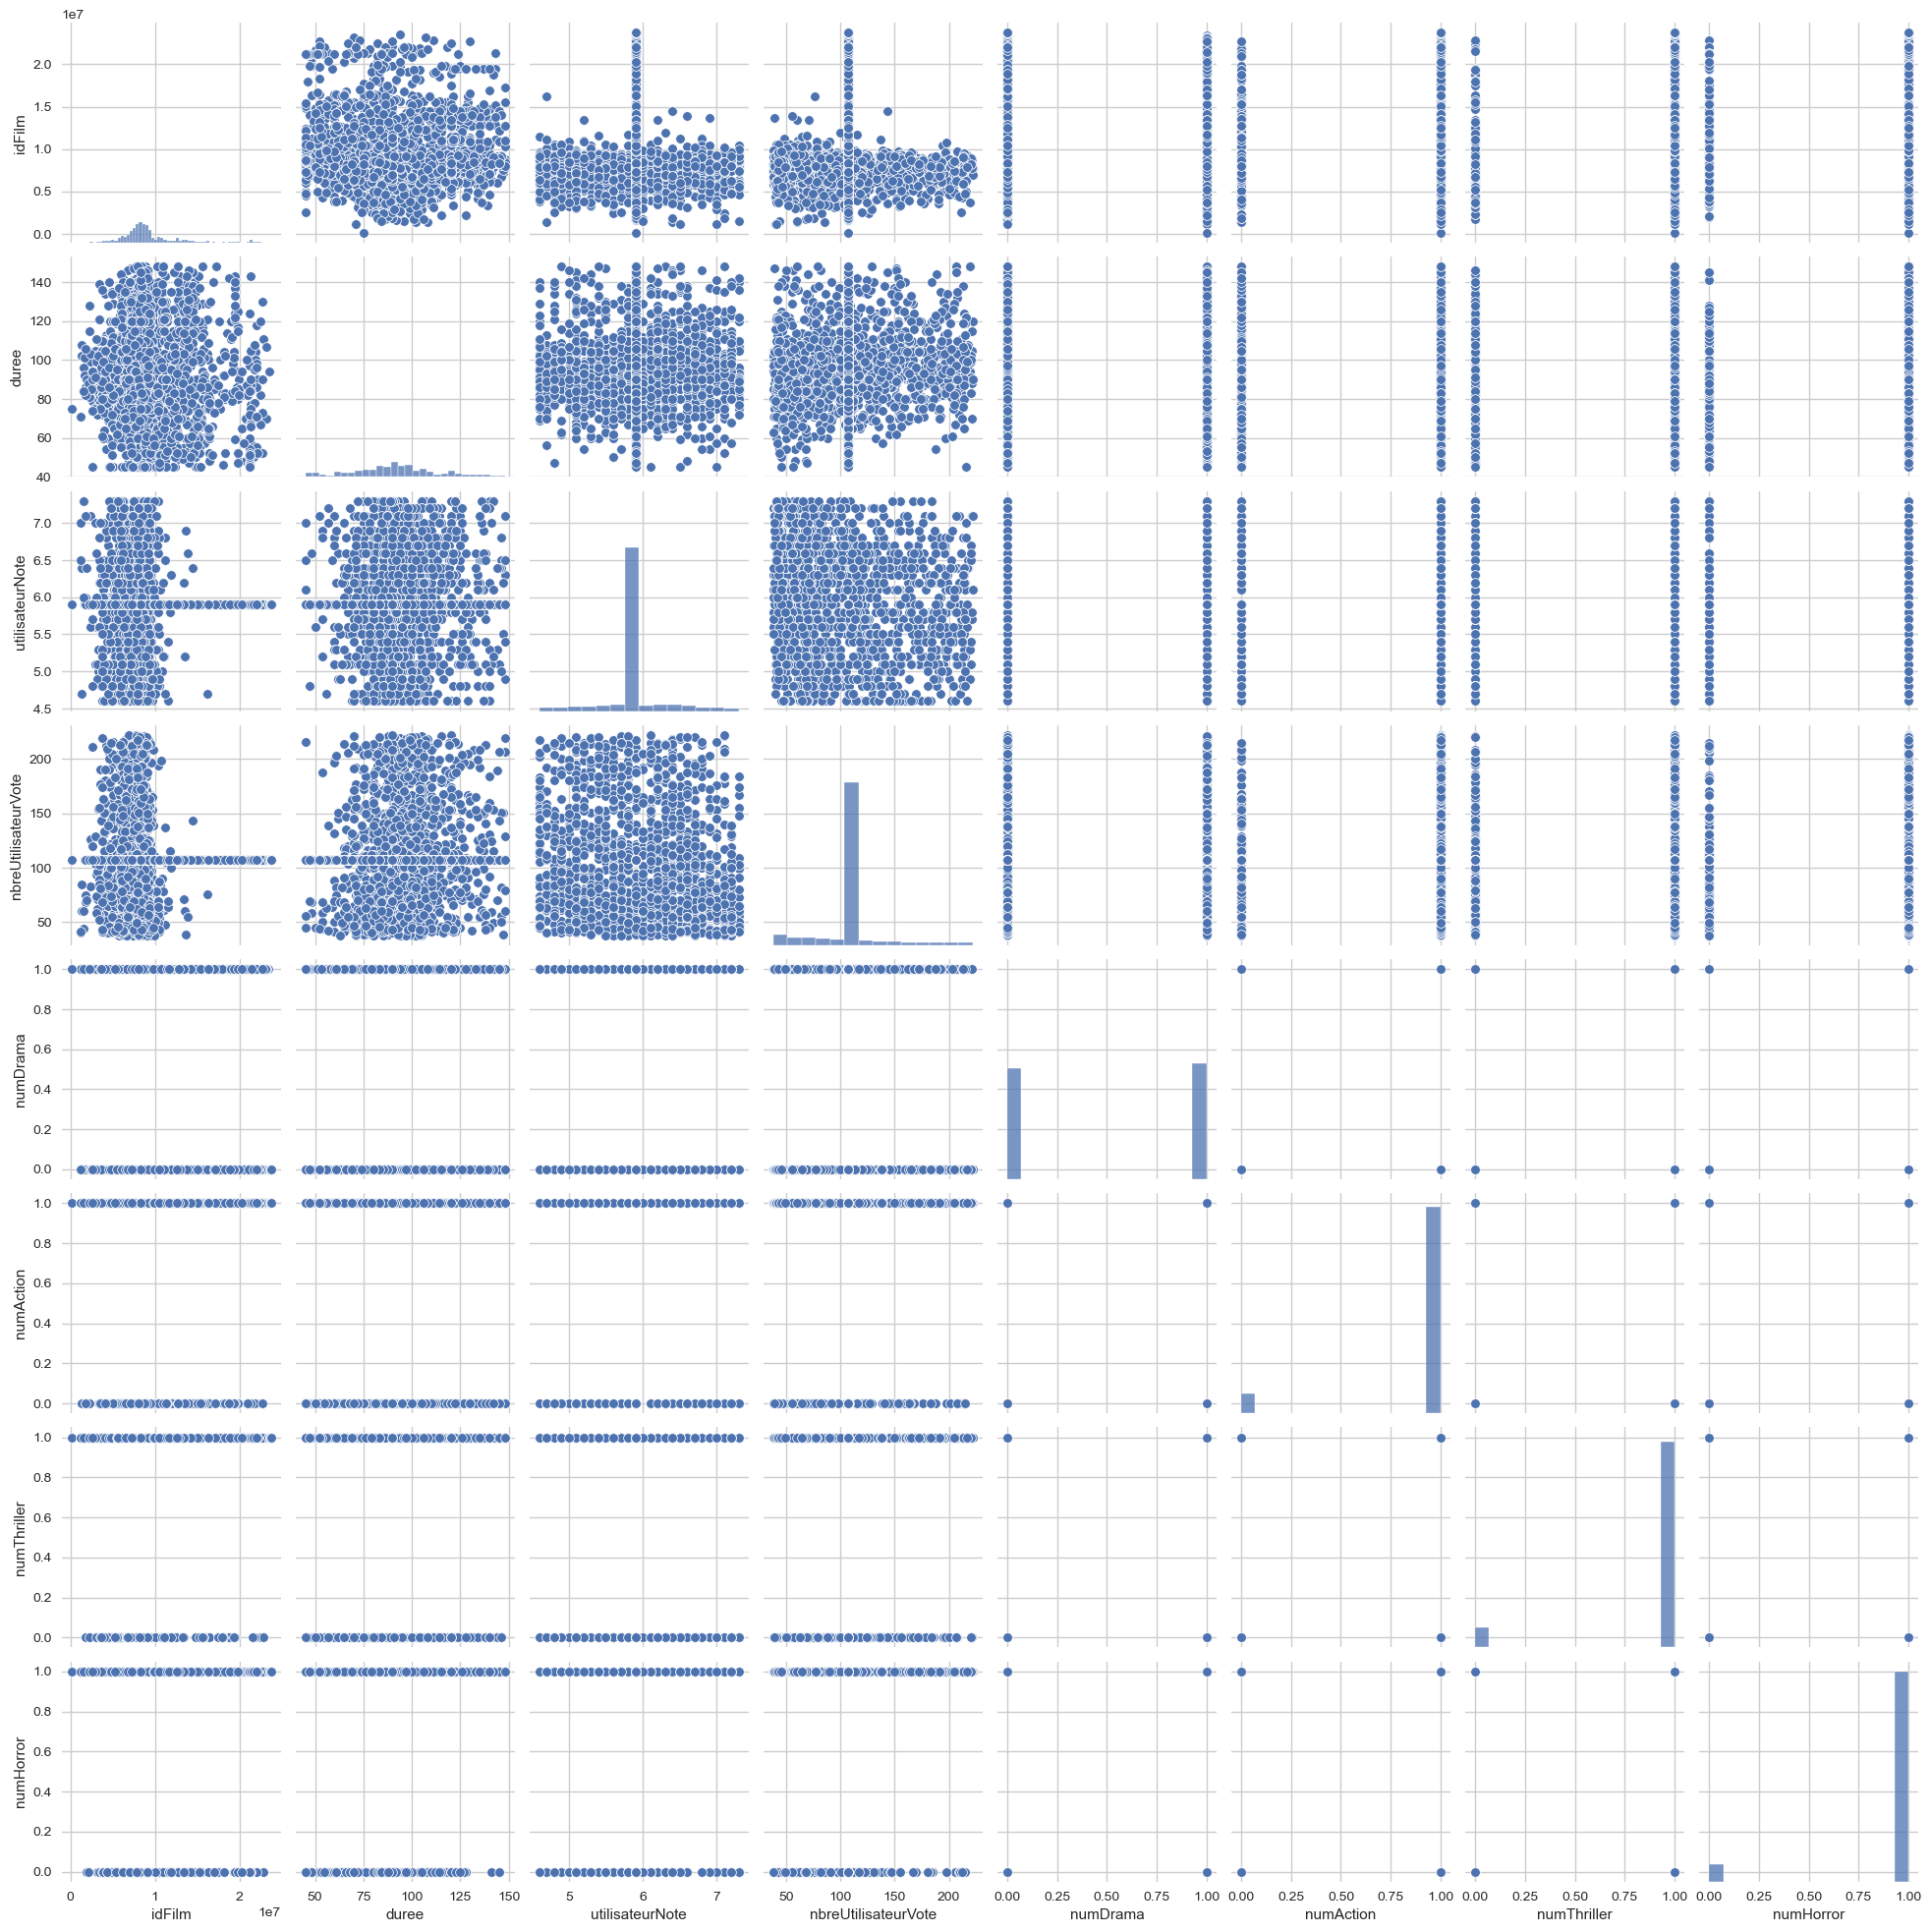

In [134]:
sns.pairplot(dfdata)

In [260]:
print("\n 6.5 prédire la note d’un film utilisateur note en fonction de 6 colonnes nbre utilisateur note log, durée minutes log, drame, action, thriller, et horreur")
dfNotes=dfdata

from scipy.stats import linregress

# Étape 1: Transformer categorie en numérique: 
transforme = LabelEncoder()
dfNotes['numDrama'] = transforme.fit_transform(dfNotes['Drama'])
dfNotes['numAction'] = transforme.fit_transform(dfNotes['Action'])
dfNotes['numThriller'] = transforme.fit_transform(dfNotes['Thriller'])
dfNotes['numHorror'] = transforme.fit_transform(dfNotes['Horror'])
dfNotes=dfNotes.fillna(0)


# Étape 2: préparation de données
coordX = dfNotes[['nbreUtilisateurNoteLog', 'dureeMinutesLog','numDrama',"numAction",'numThriller','numHorror']]
coordY = dfNotes["utilisateurNote"]
X_train, X_test, y_train, y_test = train_test_split(coordX, coordY, test_size= 0.20, random_state= 101)

display(coordX)

# Étape 3: Créer modèle
modelLR= LinearRegression().fit(X_train, y_train)


# Étape 4: Faire la prédiction de mon mondèle sur le prix
y_pred = modelLR.predict(X_test)

# Étape 5: Évaluation de la performance du modèle
print('\nBeta_0:',modelLR.intercept_)
print('Beta :',modelLR.coef_)
print('Mean Absolute Error:', mean_absolute_error(y_test,y_pred))
print('Mean Squared Error:', mean_squared_error(y_test,y_pred))
print('Mean Root Squared Error:', np.sqrt(mean_squared_error(y_test,y_pred)))




 6.5 prédire la note d’un film utilisateur note en fonction de 6 colonnes nbre utilisateur note log, durée minutes log, drame, action, thriller, et horreur


nbreUtilisateurNoteLog  dureeMinutesLog  numDrama  numAction  \
1847                 6.228819         6.870365         0          1   
10244                6.741467         6.491853         1          0   
8204                 6.741467         6.321928         0          1   
12676                6.741467         5.491853         1          1   
3518                 7.426265         6.228819         1          1   
...                       ...              ...       ...        ...   
1424                 6.845490         6.491853         0          1   
9527                 6.741467         6.857981         1          1   
4131                 6.807355         6.894818         0          1   
5811                 5.643856         6.554589         0          1   
5528                 6.741467         6.918863         0          1   

       numThriller  numHorror  
1847             0          1  
10244            1          1  
8204             1          1  
12676            1          1  
3518             1          1  
...            ...        ...  
1424             1          1  
9527             1          1  
4131             1          1  
5811             1          1  
5528             1          1  

[3133 rows x 6 columns]


Beta_0: 6.520944789701935
Beta : [-0.14432915  0.03228206 -0.07512107  0.02656146  0.06872683  0.10783635]
Mean Absolute Error: 0.2678766302749898
Mean Squared Error: 0.20042907449823263
Mean Root Squared Error: 0.4476930583538599



Vérifier les 4 conditions nécessaires pour appliquer la régression multiple
1) Vérifier la linérité par nuage de points.


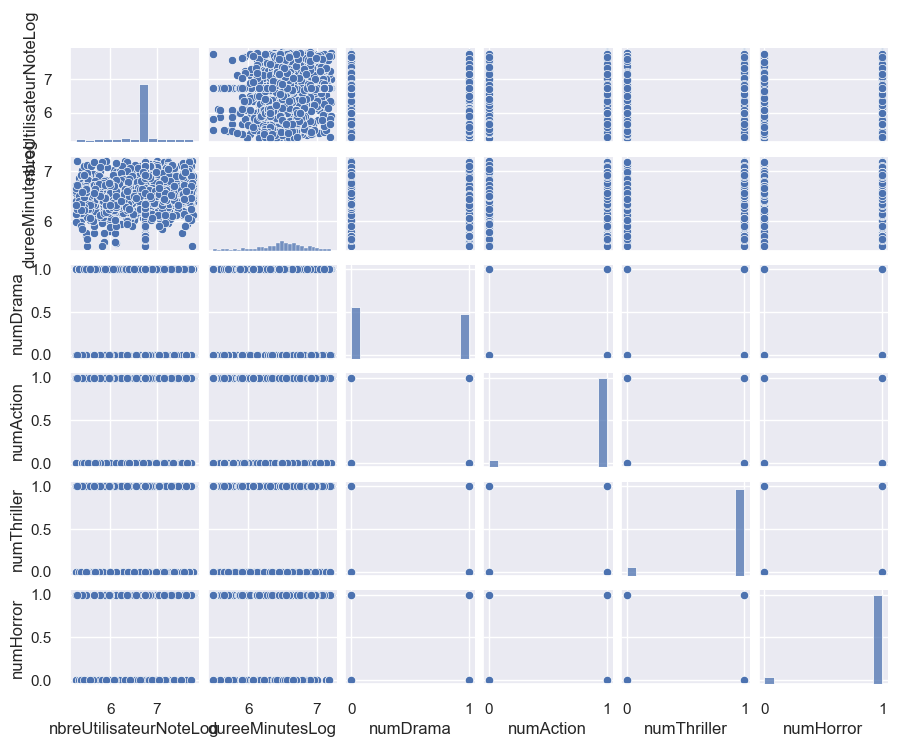

In [255]:
print("\nVérifier les 4 conditions nécessaires pour appliquer la régression multiple")
dfNotesGraph = dfNotes[['nbreUtilisateurNoteLog', 'dureeMinutesLog','numDrama',"numAction",'numThriller','numHorror']] 
sns.pairplot(dfNotesGraph, height=1.2, aspect=1.25)

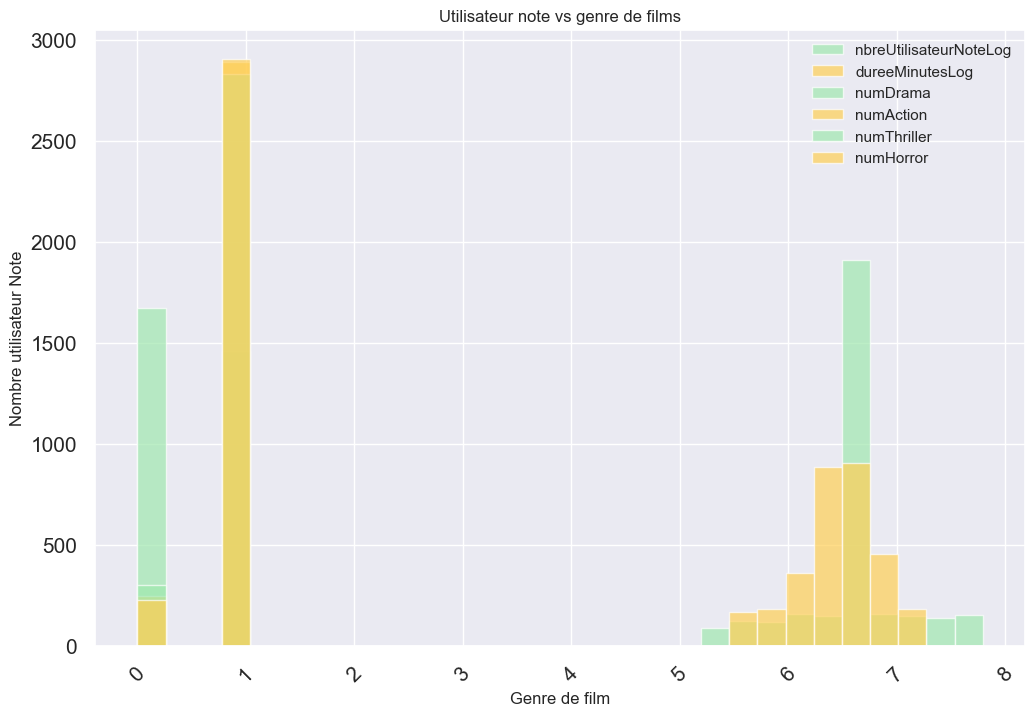

In [257]:
dfNotesGraph.plot(kind='hist',
        alpha=0.7,
        bins=30,
        title='Utilisateur note vs genre de films',
        rot=45,
        grid=True,
        figsize=(12,8),
        fontsize=15, 
        color=['#A0E8AF', '#FFCF56'])
plt.xlabel('Genre de film')
plt.ylabel("Nombre utilisateur Note");


In [267]:
######################################################################
# 6.6 Refaire la question précédente après avoir effectué une normalisation adéquate. Comparer les résultats. Remarques: Pour les deux dernières questions, on regarde 80% des données pour l’entraînement et le reste pour les tests
######################################################################

from sklearn.preprocessing import StandardScaler
print("\n 6.6 Refaire la question précédente après avoir effectué une normalisation adéquate.")
dfNotes=dfdata

from scipy.stats import linregress

# Étape 1: Transformer categorie en numérique: 
transforme = LabelEncoder()
dfNotes['numDrama'] = transforme.fit_transform(dfNotes['Drama'])
dfNotes['numAction'] = transforme.fit_transform(dfNotes['Action'])
dfNotes['numThriller'] = transforme.fit_transform(dfNotes['Thriller'])
dfNotes['numHorror'] = transforme.fit_transform(dfNotes['Horror'])
dfNotes=dfNotes.fillna(0)

# Étape 2: Standardisation des données
x = dfNotes.loc[:, ['nbreUtilisateurNoteLog', 'dureeMinutesLog','numDrama',"numAction",'numThriller','numHorror']].values
y = dfNotes.loc[:, ['utilisateurNote']].values
x = StandardScaler().fit_transform(x)

# Étape 3: préparation de données
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.20, random_state= 101)

# Étape 4: Créer modèle
modelLR= LinearRegression().fit(X_train, y_train)

# Étape 5: Faire la prédiction de mon mondèle sur le prix
y_pred = modelLR.predict(X_test)

# Étape 5: Évaluation de la performance du modèle
print('\nBeta_0:',modelLR.intercept_)
print('Beta :',modelLR.coef_)
print('Mean Absolute Error:', mean_absolute_error(y_test,y_pred))
print('Mean Squared Error:', mean_squared_error(y_test,y_pred))
print('Mean Root Squared Error:', np.sqrt(mean_squared_error(y_test,y_pred)))


 6.6 Refaire la question précédente après avoir effectué une normalisation adéquate.

Beta_0: [5.91910863]
Beta : [[-0.06930368  0.01193312 -0.03747526  0.00711804  0.02028333  0.02795539]]
Mean Absolute Error: 0.26787663027498987
Mean Squared Error: 0.20042907449823263
Mean Root Squared Error: 0.4476930583538599


nbreUtilisateurNoteLog  dureeMinutesLog  numDrama  numAction  \
0                  -0.914565         1.075150 -0.934775   0.290617   
1                   0.153056         0.051182  1.069776  -3.440954   
2                   0.153056        -0.408508 -0.934775   0.290617   
3                   0.153056        -2.654067  1.069776   0.290617   
4                   1.579189        -0.660392  1.069776   0.290617   
...                      ...              ...       ...        ...   
3128                0.369690         0.051182 -0.934775   0.290617   
3129                0.153056         1.041649  1.069776   0.290617   
3130                0.290272         1.141301 -0.934775   0.290617   
3131               -2.132786         0.220898 -0.934775   0.290617   
3132                0.153056         1.206350 -0.934775   0.290617   

      numThriller  numHorror  
0       -3.061727   0.279489  
1        0.326613   0.279489  
2        0.326613   0.279489  
3        0.326613   0.279489  
4        0.326613   0.279489  
...           ...        ...  
3128     0.326613   0.279489  
3129     0.326613   0.279489  
3130     0.326613   0.279489  
3131     0.326613   0.279489  
3132     0.326613   0.279489  

[3133 rows x 6 columns]

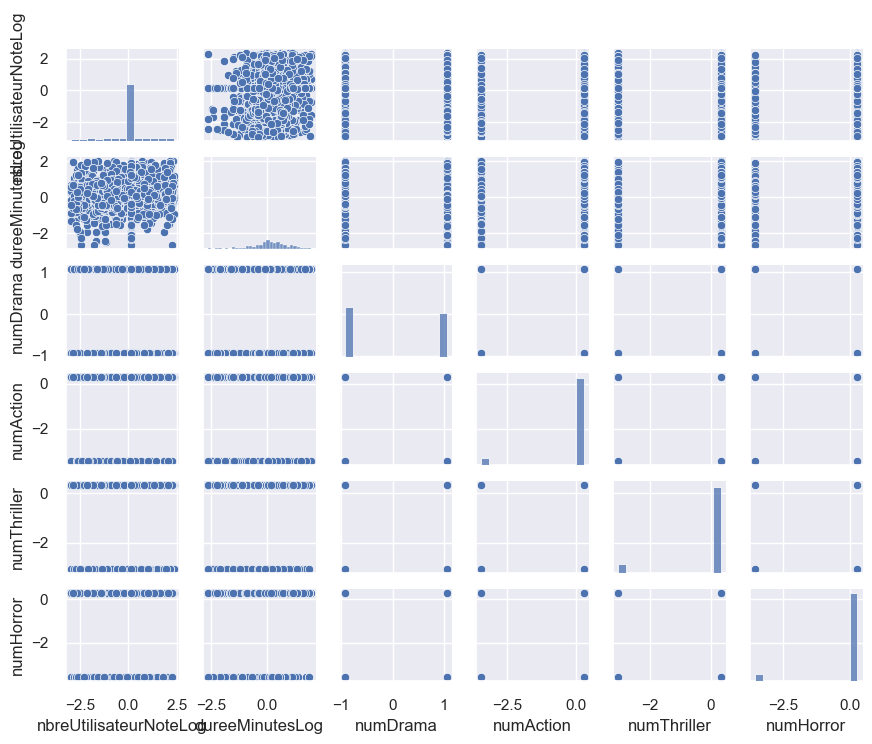

In [274]:
dfx = pd.DataFrame(x, columns = ['nbreUtilisateurNoteLog', 'dureeMinutesLog','numDrama',"numAction",'numThriller','numHorror'])
display(dfx)
dfNotesGraph = dfx[['nbreUtilisateurNoteLog', 'dureeMinutesLog','numDrama',"numAction",'numThriller','numHorror']] 
sns.pairplot(dfNotesGraph, height=1.2, aspect=1.25)

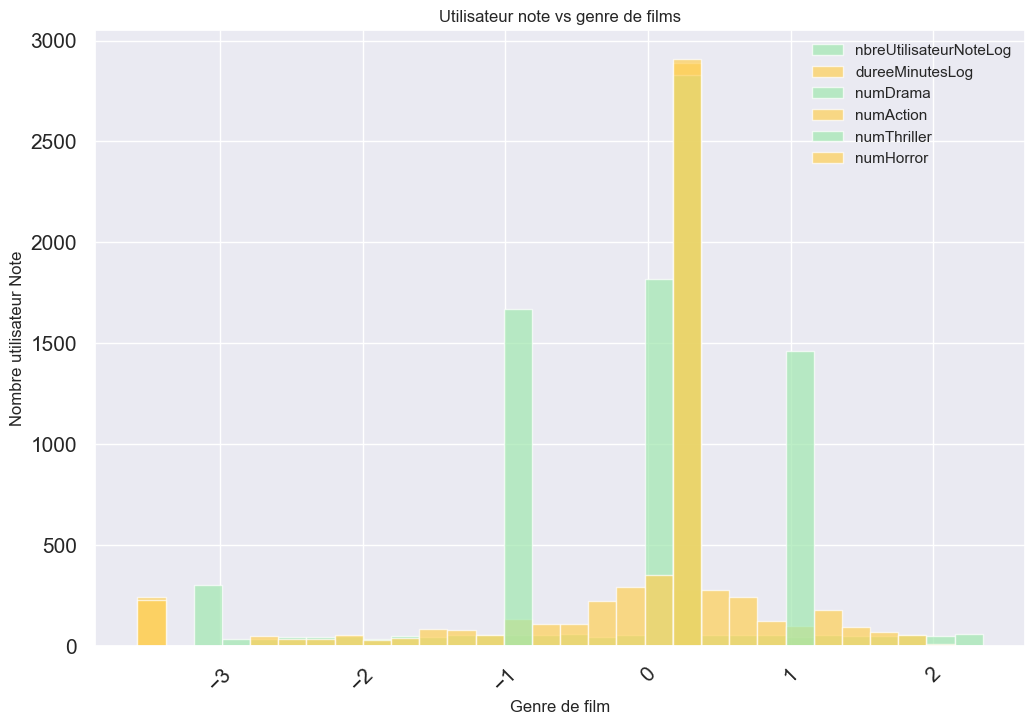

In [275]:
dfNotesGraph.plot(kind='hist',
        alpha=0.7,
        bins=30,
        title='Utilisateur note vs genre de films',
        rot=45,
        grid=True,
        figsize=(12,8),
        fontsize=15, 
        color=['#A0E8AF', '#FFCF56'])
plt.xlabel('Genre de film')
plt.ylabel("Nombre utilisateur Note");